# MXN442 Assignment 1
- Student Number: 10515402
- First Name: Aidan
- Last Name: Lockwood

## Assignment Setup
Installing required libraries

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ISLP.models import (ModelSpec as MS,
                         Stepwise,
                         sklearn_selected,
                         sklearn_selection_path)
import statsmodels.api as sm
import seaborn as sns
from functools import partial

from sklearn.preprocessing import StandardScaler


Loading required data

In [2]:
df = pd.read_csv('data/assignment1_data.csv')
df

,age,income,credit_score,years_employed,debt_to_income,num_credit_cards,education,marital_status,credit_limit,loan_default
0,52,25874.0,569,3.9,0.269,5,1,0,9131,0
1,43,NaN,613,0.1,0.059,5,0,1,9690,0
2,55,20000.0,578,18.3,0.088,2,2,1,15311,0
3,68,27887.0,663,6.0,0.182,3,3,0,13221,0
4,41,65268.0,794,15.2,0.162,3,3,0,24805,0
...,...,...,...,...,...,...,...,...,...,...
4995,44,102835.0,541,3.5,0.134,3,0,1,22262,0
4996,56,20000.0,798,NaN,0.288,3,2,1,8700,0
4997,80,20656.0,807,7.6,0.252,5,1,1,9876,0
4998,57,53993.0,544,3.4,0.422,2,1,1,8790,0


## Question 1: Linear Regression and Model Selection (12 Marks)

Banks need to set appropriate credit limits for customers based on their financial profiles. Setting limits too low may result in lost revenue opportunities, while setting them too high increases exposure to potential losses. The challenge is to develop a model that can accurately predict optimal credit limits using customer demographic, financial, and behavioural characteristics.

<b>a) Multiple Linear Regression (3 marks) </b>
- Handle missing values using mean imputation 
- Split data into training (70%) and test (30%) sets. Fit a multiple linear regression model using all features to predict `credit_limit` (1) 
- Interpret the coefficients of the three most significant predictors (1)

Handling the missing values using mean imputation

In [3]:
# Checking for the missing values in the dataset
data_columns = df.columns.to_list()

for column in data_columns:
    print(f'Column {column} has {df[column].isna().sum()} missing values')

Column age has 0 missing values
Column income has 150 missing values
Column credit_score has 0 missing values
Column years_employed has 150 missing values
Column debt_to_income has 0 missing values
Column num_credit_cards has 0 missing values
Column education has 0 missing values
Column marital_status has 0 missing values
Column credit_limit has 0 missing values
Column loan_default has 0 missing values


It appears that both `income` and `years_employed` have missing values. Thus the mean will be calculated for those values. The mean for each variable will be input into the NaN values

In [4]:
df['income'].mean()

np.float64(51458.36804123711)

In [ ]:
# Calculating the mean values 
mean_income = round(df['income'].mean(), 2)
mean_years_employed = round(df['years_employed'].mean(), 2)

# Replacing the NaN values for each column with their respective means 
df['income'] = df['income'].fillna(mean_income)
df['years_employed'] = df['years_employed'].fillna(mean_years_employed)

# Checking the fill worked
for column in data_columns:
    print(f'Column {column} has {df[column].isna().sum()} missing values')

Column age has 0 missing values
Column income has 0 missing values
Column credit_score has 0 missing values
Column years_employed has 0 missing values
Column debt_to_income has 0 missing values
Column num_credit_cards has 0 missing values
Column education has 0 missing values
Column marital_status has 0 missing values
Column credit_limit has 0 missing values
Column loan_default has 0 missing values


The mean imputation has been completed.

Going to also convert the categorical variables into the required data types

In [17]:
categorical_variables = [
    'education',
    'marital_status',
    'loan_default'
]

for index, column in enumerate(data_columns):
    if column in categorical_variables:
        df[column] = df[column].astype('category')

In [18]:
df.dtypes

age                    int64
income               float64
credit_score           int64
years_employed       float64
debt_to_income       float64
num_credit_cards       int64
education           category
marital_status      category
credit_limit           int64
loan_default        category
dtype: object

Now time to split data into training and test splits, then generate a multiple linear regression model, fitting it to the training data.

In [6]:
df_size = df.shape[0]

training_size = int(df_size * 0.7)
test_size = df_size - training_size

training_data = df[0:training_size]
test_data = df[training_size:]

In [7]:
test_data

,age,income,credit_score,years_employed,debt_to_income,num_credit_cards,education,marital_status,credit_limit,loan_default
3500,63,269510.0,702,9.00,0.107,4,0,0,48686,0
3501,36,25303.0,678,2.70,0.628,1,2,0,2883,0
3502,46,165399.0,742,16.30,0.053,3,0,0,39412,0
3503,46,29421.0,715,11.00,0.039,3,1,1,14974,0
3504,37,20000.0,736,4.40,0.140,5,0,2,10242,0
...,...,...,...,...,...,...,...,...,...,...
4995,44,102835.0,541,3.50,0.134,3,0,1,22262,0
4996,56,20000.0,798,8.26,0.288,3,2,1,8700,0
4997,80,20656.0,807,7.60,0.252,5,1,1,9876,0
4998,57,53993.0,544,3.40,0.422,2,1,1,8790,0


Now to fit the data to a MLR.
Note that:
- `credit_limit` is the response variable

In [72]:
training_predictors = training_data.columns.drop(['credit_limit', 'loan_default', 'education', 'marital_status']).to_list()

# The dataset to be used in the regression
training_data_X = training_data[training_predictors]

# Experimenting with adjusting the scaling of the variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(training_data_X)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=training_predictors)
X_train_scaled['education'] = training_data['education']
X_train_scaled['marital_status'] = training_data['marital_status']

train_design = MS(training_predictors)
train_design = train_design.fit(training_data_X)
X_train = train_design.transform(training_data)


mlr_model = sm.OLS(np.array(training_data['credit_limit']), X_train_scaled)

results = mlr_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.834
Model:                            OLS   Adj. R-squared (uncentered):              0.833
Method:                 Least Squares   F-statistic:                              2188.
Date:                Wed, 20 Aug 2025   Prob (F-statistic):                        0.00
Time:                        17:46:02   Log-Likelihood:                         -35989.
No. Observations:                3500   AIC:                                  7.199e+04
Df Residuals:                    3492   BIC:                                  7.204e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                -85.6472    119.739     -0.715      0.474    -320.412     149.118
income            7209.3665    119.841     60.158      0.000    6974.402    7444.331
credit_score       979.7520    119.739      8.182      0.000     744.987    1214.517
years_employed    2795.1014    119.871     23.318      0.000    2560.077    3030.126
debt_to_income   -2016.3242    119.795    -16.832      0.000   -2251.199   -1781.450
num_credit_cards  -436.5075    119.733     -3.646      0.000    -671.261    -201.754
education         5694.5199     87.262     65.258      0.000    5523.431    5865.609
marital_status    4867.3359    149.342     32.592      0.000    4574.529    5160.143
==============================================================================
Omnibus:                       33.401   Durbin-Watson:                   1.616
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.348
Skew:                           0.141   Prob(JB):                     3.87e-10
Kurtosis:                       3.467   Cond. No.                         2.53
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<b>Need to discuss the multicolinearity in the report</b>

<Axes: >

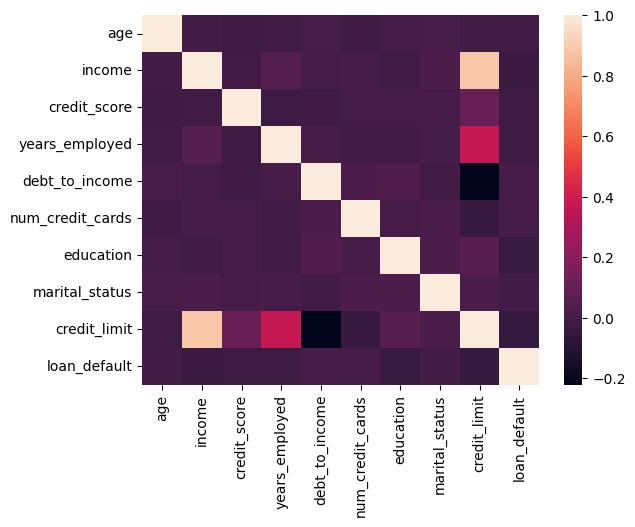

In [12]:
sns.heatmap(training_data.corr())

<b>Model Selection (4 marks)</b>
- Implement forward selection using AIC (1)
- Implement backward elimination using AIC (1)
- Compare the selected variables from both methods. Discuss which approach selects more variables and why (1)

In [ ]:
# Defining the mallory CP Function for scoring 
def mallory_cp(sigma2 , estimator , X, Y):
    " Negative Cp statistic "
    n, p = X.shape
    Yhat = estimator .predict(X)
    RSS = np.sum ((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

Y = np.array(training_data['credit_limit'])
X = train_design.transform(training_data)

sigma_2 = sm.OLS(training_data_X, Y).fit().scale 
negative_cp = partial(mallory_cp, sigma_2)

ValueError: shapes (3500,8) and (3500,8) not aligned: 8 (dim 1) != 3500 (dim 0)

In [35]:
forward_MSE.selected_state_ == backward_MSE.selected_state_

True

<b>Regularisation (5 marks)</b>
- Implement Ridge and Lasso Regression with 5-fold cross validation (2)
- Plot the cross-validation error vs lambda for both methods (1)
- Calculate test set RMSE for all five models (full, forward, backward, Ridge, Lasso) (2)

**Can consider a range of values for lambda**